<a href="https://colab.research.google.com/github/shy00n123/solid-couscous/blob/main/Big_Mac_Index_Happiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Relationship Between World Happiness and the BigMac Index
Kyle Pelham (kpelham@calpoly.edu)

Shayan Golshan (ssgolsha@calpoly.edu)

**February 2023**


## Introduction

In this notebook, we are exploring the correlation of a country's Big Mac Index to its overall happiness.

The Big Mac index is an economic measurement of consumer purchasing power by comparing the price of a single Big Mac in other countries to the cost of a Big Mac in the United States. The Purchasing Power Parity(PPP) theory suggests that a product or good will cost the same across all countries after converting to their local currency. However, this is an ideal situation and in reality there are currencies that are overvalued(they pay more in USD) and undervalued(they pay less in USD). The Big Mac Index is fun way to get an approximate measurement of global buying power since the Big Mac is a common item that is sold across over 150+ countries and is essentially made the same way.

**The data used to complete this analysis can be found below:**

Big Max Index Data (using adjusted index): [https://github.com/TheEconomist/big-mac-data](https://github.com/TheEconomist/big-mac-data)

World Happiness Report: [https://worldhappiness.report/archive/](https://worldhappiness.report/archive/)

Our hypothesis is that there is a moderate to postitive correlation between a Country's Big Mac Index and their overall happiness. In other words, based on the Big Mac Index, countries with higher valued currencies are happier on average than those with lower valued currencies (r being the pearson coefficient).

**Null Ho:**
r >= 0.30

**Alternative Ho:**
r < 0.30



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading in the Data

To perform this analysis, Big Mac Data must be joined onto the Happiness data. First, the happiness data for each year needs to be merged together, however,  the countries listed in each year's happiness report slightly vary from year to year. To fix this, each year's data is filtered on a common list of countries across all eight years and then is merged by stacking the rows for each.

In [ ]:
# Read in World Happiness data from Google Drive Folder
happy2015 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2015.csv')
happy2016 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2016.csv')
happy2017 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2017.csv')
happy2018 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2018.csv')
happy2019 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2019.csv')
happy2020 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2020.csv')
happy2021 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2021.csv')
happy2022 = pd.read_csv('/content/drive/MyDrive/BigMac Data/2022.csv')


In [ ]:
# Create Year column for each dataset
happy2015['Year'] = '2015'
happy2016['Year'] = '2016'
happy2017['Year'] = '2017'
happy2018['Year'] = '2018'
happy2019['Year'] = '2019'
happy2020['Year'] = '2020'
happy2021['Year'] = '2021'
happy2022['Year'] = '2022'

# Create a list of each df for later iteration
happiness_data = [happy2015,happy2016,happy2017,happy2018,happy2019,happy2020,happy2021,happy2022]

In [ ]:
# Required columns for subsetting
columns_to_keep = ['Country', 'Happiness Score', 'Year']

# Create an empty list to store the extracted dataframes
happiness_data_reduced = []

# loop over each dataframe in happiness_data
for df in happiness_data:
    # extract the desired columns and assign it back to the same dataframe
    df = df[columns_to_keep]
    # append the modified dataframe to the happiness_data_reduced list
    happiness_data_reduced.append(df)

In [ ]:
# Get the set of countries in each dataframe
country_sets = [set(df['Country']) for df in happiness_data_reduced]

# Find the intersection of all the sets
common_countries = set.intersection(*country_sets)

# Filter each dataframe to include only the common countries
filtered_dfs = [df[df['Country'].isin(common_countries)] for df in happiness_data_reduced]

# Bind rows of each happiness dataset together
final_happiness = pd.concat(filtered_dfs)
final_happiness['Happiness Score'] = pd.to_numeric(final_happiness['Happiness Score'])
final_happiness.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 145
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          936 non-null    object 
 1   Happiness Score  936 non-null    float64
 2   Year             936 non-null    object 
dtypes: float64(1), object(2)
memory usage: 29.2+ KB


The Big Mac Index data is merged with the happiness data by performing an inner join on Country and Year. All data before 2015 is dropped to match up with the happiness data. Uncommon countries were looked at externally for misspellings but there were none.

In [ ]:
bigmac = pd.read_csv('/content/drive/MyDrive/BigMac Data/big-mac-adjusted-index.csv')

bigmac = bigmac[bigmac['date'].str.contains('01-01')]

# separate the date column into year and month and filter where year is greater than 2015. 
bigmac["year"] = bigmac["date"].str.split("-").str.get(0)
bigmac["month"] = bigmac["date"].str.split("-").str.get(1)
bigmac["Country"] = bigmac["name"]
bigmac = bigmac[bigmac["year"]>="2015"]

# Drop the date column
bigmac.drop("date", axis=1, inplace=True)
bigmac.drop("month", axis=1, inplace=True)
bigmac.drop("name", axis=1, inplace=True)

# concatenate name and year in a new column
bigmac["Country_Year"] = bigmac["Country"] + " " + bigmac["year"]
#print(bigmac)

# convert the year column to string
final_happiness["Year"] = final_happiness["Year"].astype(str)
final_happiness["Country_Year"] = final_happiness["Country"] + " " + final_happiness["Year"]

# Join the datasets on key column
merged = pd.merge(bigmac, final_happiness, on='Country_Year', how='inner', suffixes=('_1', '_2'))
#print(merged)

# Select rows needed for analysis
merged2 = merged[['USD', 'Country_1','Happiness Score','Year']]

# Rename USD to proper name
merged2 = merged2.rename({'USD': 'BigMacIndex(USD)'}, axis=1)

merged2.head()

/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-7-412aa2338a88>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigmac["Country_Year"] = bigmac["Country"] + " " + bigmac["year"]


,BigMacIndex(USD),Country_1,Happiness Score,Year
0,0.02297,Argentina,6.574,2015
1,0.00560,Australia,7.284,2015
2,0.75430,Brazil,6.983,2015
3,0.18177,Canada,7.427,2015
4,0.04755,Chile,6.670,2015


# Analyzing the Data

## Plotting Big Mac Index and Happiness Score

[Text(0.5, 1.0, 'Big Mac Index')]

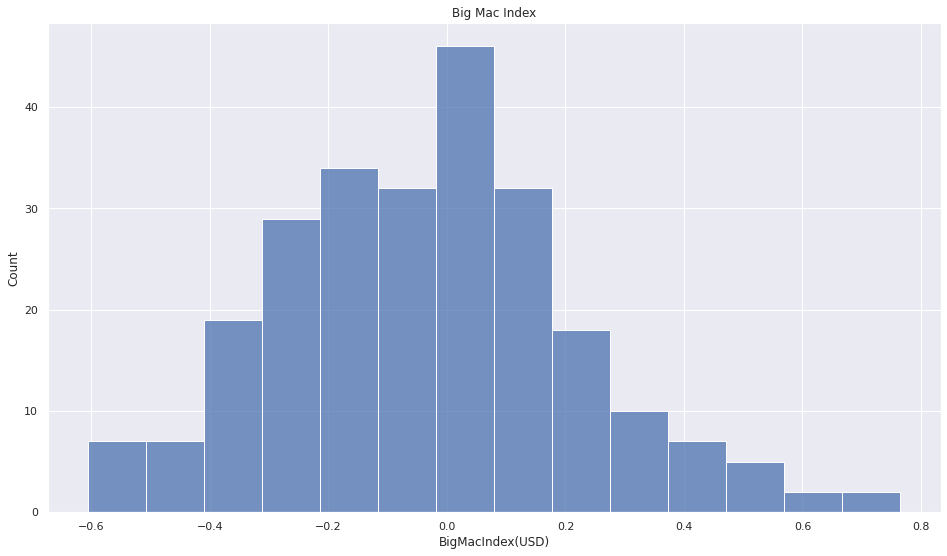

In [ ]:
# Box plot for Big Mac Index by year. Each observation is one country
sns.set(rc={'figure.figsize':(16,9)})
sns.histplot(x="BigMacIndex(USD)", data=merged2, bins = 'auto').set(title='Big Mac Index')

[Text(0.5, 1.0, 'Happiness Score')]

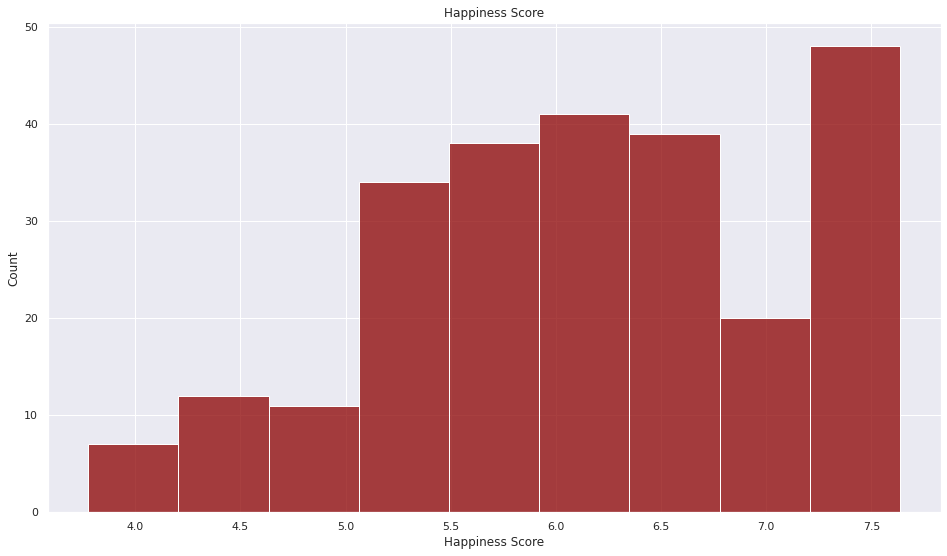

In [ ]:
sns.set(rc={'figure.figsize':(16,9)})
sns.histplot(x="Happiness Score", data=merged2, bins = 'auto', color = 'darkred').set(title='Happiness Score')

## Taking a look at the happiest and least happy countries

In [ ]:
# Group by country and calculate mean happiness score
happiness_by_country = merged2.groupby('Country_1').mean()

# Looking at the happiest countries on average
happiness_by_country.sort_values(ascending = False, by = 'Happiness Score').head()

,BigMacIndex(USD),Happiness Score
Country_1,,
Denmark,0.053869,7.569429
Switzerland,0.502316,7.520000
Norway,0.307080,7.494571
Sweden,0.363260,7.334714
New Zealand,0.058720,7.291714


In [ ]:
# Looking at the least happy countries on average
happiness_by_country.sort_values(ascending = True, by = 'Happiness Score').head()

,BigMacIndex(USD),Happiness Score
Country_1,,
India,-0.215606,4.155000
Jordan,-0.098945,4.273500
Sri Lanka,0.149085,4.343500
Egypt,-0.289744,4.349571
South Africa,-0.342597,4.789429


## Low happiness plot time series for each year 

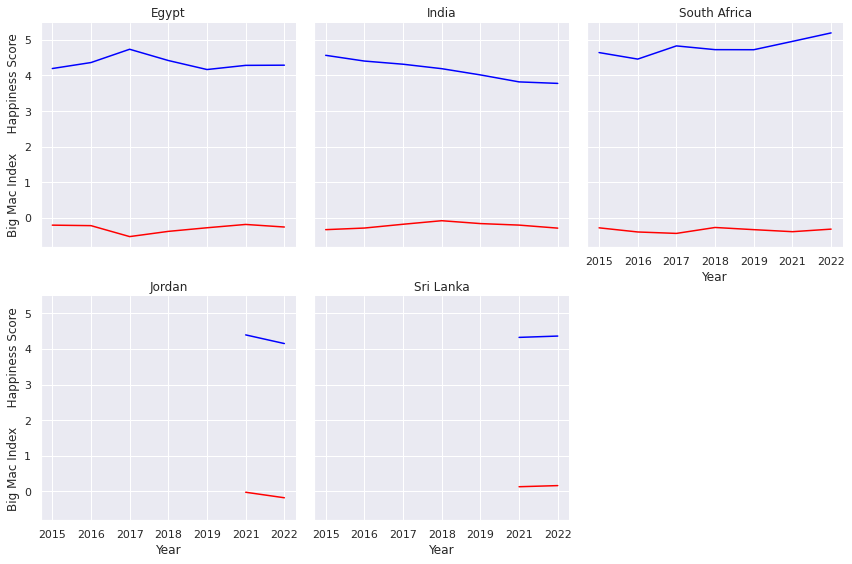

In [ ]:
low_country = merged2.query("Country_1 == 'India' or Country_1 == 'Jordan' or Country_1 == 'Sri Lanka' or Country_1 == 'Egypt' or Country_1 == 'South Africa'")

# Create a FacetGrid object
g = sns.FacetGrid(low_country, col="Country_1", col_wrap=3, height=4)

# Plot the line plots for each country
g.map(sns.lineplot, "Year", "BigMacIndex(USD)", color="red")
g.map(sns.lineplot, "Year", "Happiness Score", color="blue")

# Add a legend with color labels
import matplotlib.pyplot as plt

# Set axis labels and titles
g.set_axis_labels("Year", "Big Mac Index     Happiness Score")
g.set_titles("{col_name}")

From the graph above, you can see that changes (or the lack there of) in the big mac index may have corresponding effects on happiness for the country. The countries that undervalue the Big Mac have less buying power according to the Big Mac Index and we think this may contribute to the country's overall unhappiness.  

This, however, does not hold true for all of our cases.  Sri Lanka and Denmark have Big Mac Indices that move into opposite directions.  Sri Lanka has a higher Big Mac Index (positive) and a low happiness score while Denmark has a lower Big Mac Index with the highest happiness score.  


## High happiness plot time series for each year




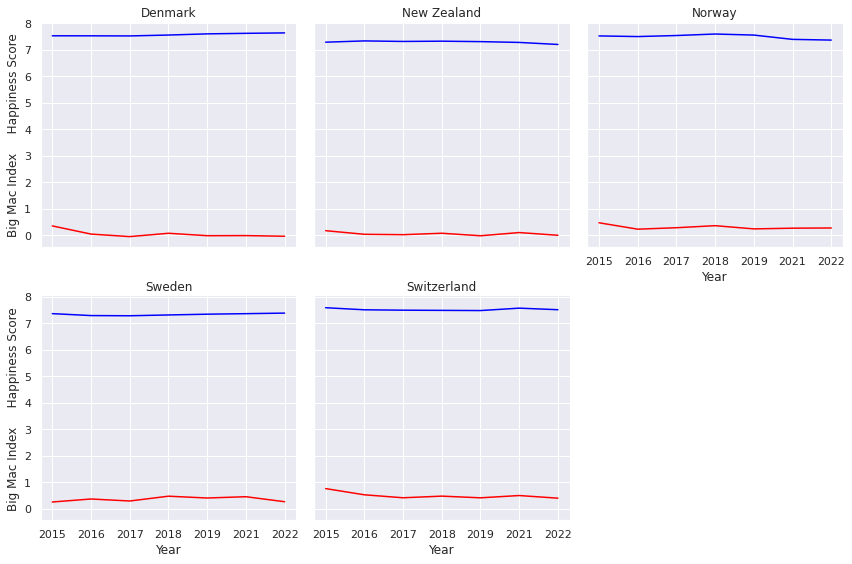

In [ ]:
high_country = merged2.query("Country_1 == 'Denmark' or Country_1 == 'Switzerland' or Country_1 == 'Norway' or Country_1 == 'Sweden' or Country_1 == 'New Zealand'")

# Create a FacetGrid object
g = sns.FacetGrid(high_country, col="Country_1", col_wrap=3, height=4)

# Plot the line plots for each country
g.map(sns.lineplot, "Year", "BigMacIndex(USD)", color="red")
g.map(sns.lineplot, "Year", "Happiness Score", color="blue")

# Add a legend with color labels
import matplotlib.pyplot as plt

# Set axis labels and titles
g.set_axis_labels("Year", "Big Mac Index     Happiness Score")
g.set_titles("{col_name}")

Again, we can see there may be some slight corresponding effects between the big mac index and happiness for the happiest countries as well. As mentioned before, we can see Denmark has a Big Mac Index that has trended slightly above or below 0 yest still has the highest overall happiness score.

# Quadrant Analysis

With examples like Sri Lanka and Denmark, creating a scatterplot may reveal a more direct relationship between happiness and the bigmac index while highlighting some additional outliers.

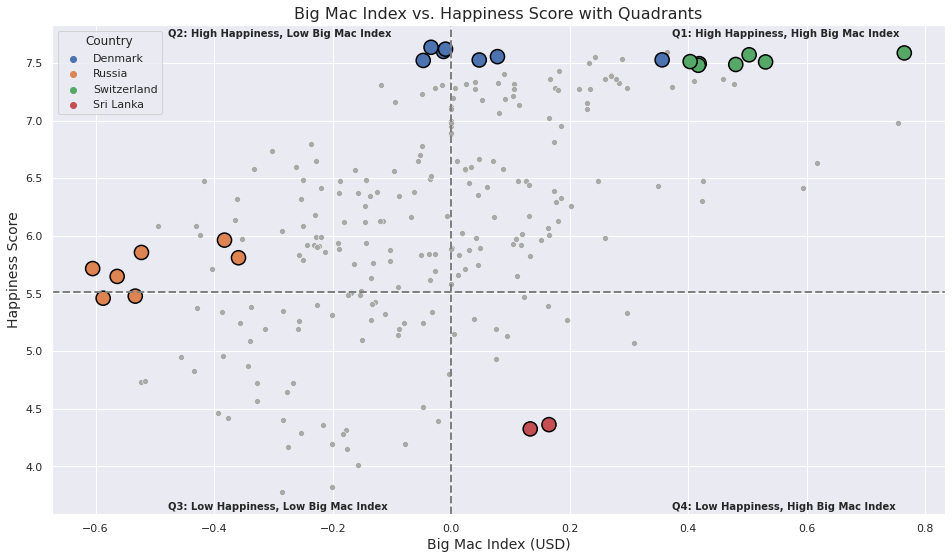

In [ ]:
outliers = merged2[merged2['Country_1'].isin(["Denmark", "Sri Lanka", 'Russia', 'Switzerland'])]
sns.set(rc={'figure.figsize':(16,9)})
fig, ax = plt.subplots()
sns.scatterplot(x="BigMacIndex(USD)", y="Happiness Score", color = 'darkgrey', data=merged2)
sns.scatterplot(x="BigMacIndex(USD)", y="Happiness Score", hue='Country_1',data=outliers, marker='o', s=200, edgecolor='black', linewidth=1.5, ax=ax)

legend = ax.legend()
legend.set_title("Country")


ax.axhline(y=merged2['Happiness Score'].median()-0.61, color='gray', linestyle='--', lw=2)
ax.axvline(x=merged2['BigMacIndex(USD)'].median()+0.028, color='gray', linestyle='--', lw=2)
ax.text(merged2['BigMacIndex(USD)'].median()+0.4, merged2['Happiness Score'].median()+1.6, 'Q1: High Happiness, High Big Mac Index', fontsize=10, fontweight='bold')
ax.text(merged2['BigMacIndex(USD)'].median()-0.45, merged2['Happiness Score'].median()+1.6, 'Q2: High Happiness, Low Big Mac Index', fontsize=10, fontweight='bold')
ax.text(merged2['BigMacIndex(USD)'].median()-0.45, merged2['Happiness Score'].median()-2.5, 'Q3: Low Happiness, Low Big Mac Index', fontsize=10, fontweight='bold')
ax.text(merged2['BigMacIndex(USD)'].median()+0.4, merged2['Happiness Score'].median()-2.5, 'Q4: Low Happiness, High Big Mac Index', fontsize=10, fontweight='bold')


plt.title('Big Mac Index vs. Happiness Score with Quadrants', fontsize=16)
plt.xlabel('Big Mac Index (USD)', fontsize=14)
plt.ylabel('Happiness Score', fontsize=14)

plt.show()

## Testing for correlation
Looking at this regression plot, we can see a rough positive, linear trend. 

<AxesSubplot:xlabel='BigMacIndex(USD)', ylabel='Happiness Score'>

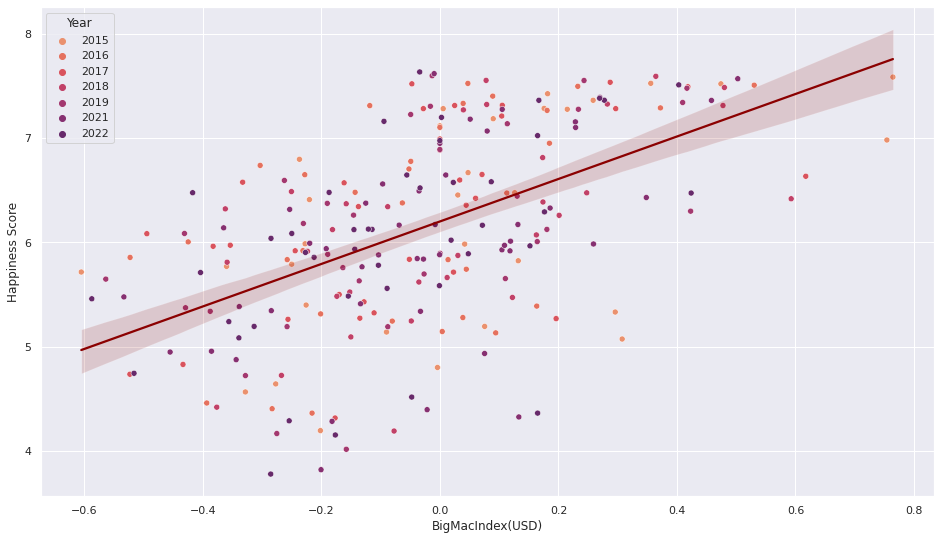

In [ ]:
# above table visualized
sns.set(rc={'figure.figsize':(16,9)})
sns.scatterplot(x="BigMacIndex(USD)", y="Happiness Score", hue = 'Year' ,palette="flare", data= merged2)
sns.regplot(x="BigMacIndex(USD)", y="Happiness Score", scatter = False,color = 'darkred', data= merged2)

In [ ]:
# find r coeificient and p value
r, p = pearsonr(merged2['BigMacIndex(USD)'], merged2['Happiness Score'])

print(r,p)

0.5429185430249961 1.4428401049526333e-20


The Pearson's R test indicates with a very low p value (nearly zero) that there is a moderately strong correlation (0.54) between the Big Mac Index and Happiness.

# Conclusion

Based on our visual and statistical analysis, we conclude that there is a moderate positive linear relationship between the Big Mac Index and overall happiness for a given country, and we fail to reject our original hypothesis. 

This makes sense as countries with a currency that is undervalued (Low Big Mac Index) may not have be able to afford imported goods that the more economically healthy countries would. In other words, their imports are much more expensive than their exports. This would likely contribute to unhappiness. 

On the other side of things, countries with an overvalued currency (High Big Mac Index) are in a situation where their imports are cheaper than their exports. It is not surprising that they would be much happier.